In [1]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import save_img

import numpy as np

import matplotlib.pyplot as plt

# Silence TQDM progress bar
from tqdm import tqdm
from functools import partialmethod

tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)



2022-12-06 19:52:45.499815: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-06 19:52:46.360550: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/falconskull/anaconda3/envs/xai/lib/
2022-12-06 19:52:46.360627: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/falconskull/anaconda3/envs/xai/lib/
2022-12-06 19:52:46.360634: W tensorflow/com

# Parameters in the code

In [73]:
param_img_size = (224,224)
param_batch_size = 1
# The data folder must contain one folder for each class
path_data = "./data_fer" 

## Initializes the dataset

In [82]:
# TODO Check label_mode is categorical as param
train_original_ds = image_dataset_from_directory(
        path_data,
        shuffle=False,
        
        seed=13,
        image_size=param_img_size,
        batch_size=param_batch_size,
    )

Found 68 files belonging to 4 classes.


## Select the transformations to apply

In [94]:
def selected_transf(x):
#     x = tf.image.adjust_contrast(x, 1)
#     x = tf.image.adjust_contrast(x, 0.9)
    return x

train_ds = (train_original_ds.map(
  lambda x, y: (selected_transf(x), y)))
# train1_ds.map(tf.image.adjust_contrast, 2.)

## Example of images and their labels

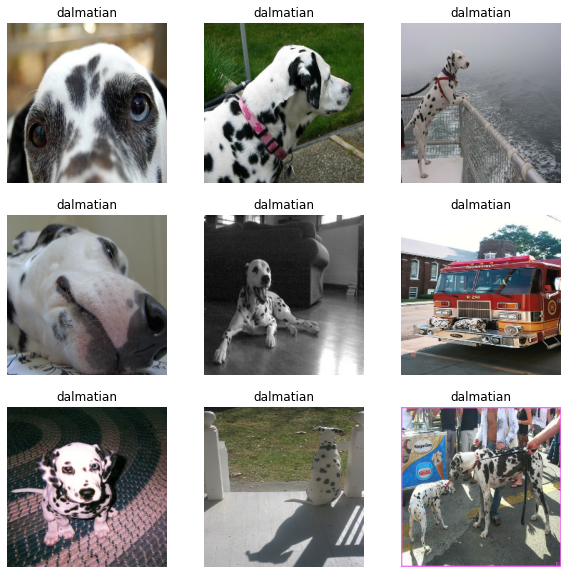

In [95]:
image_batch, label_batch = next(iter(train_ds))
class_names = train_original_ds.class_names
plt.figure(figsize=(10, 10))
for i in range(param_batch_size):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

# Helper: Dictionary from class name to id

In [5]:
import pandas as pd
df_classes = pd.read_csv('class_to_id.csv')
dict_classes = dict(zip(df_classes.name, df_classes.id))

# dict_classes['guillotine']

# Instantiates the MobileNet architecture

In [6]:
from tensorflow.keras.applications import MobileNetV3Large, MobileNetV3Small
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow.keras as keras

model = MobileNetV3Large(
    input_shape= (224,224,3),
    #alpha=1.0,
    minimalistic=False,
    #include_top=True,
    weights="imagenet",
    #input_tensor=None,
    classes=1000,
    #pooling=None,
    dropout_rate=0.2,
    classifier_activation="softmax",
    include_preprocessing=True,
) 

## Get predictions for the dataset

In [7]:
## See the prediction
predictions = model.predict(train_ds)
# results = tf.keras.applications.mobilenet.decode_predictions(predictions)


2022-12-06 19:52:50.797913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-12-06 19:52:51.043408: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-06 19:52:51.043789: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-06 19:52:51.043818: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:85] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-06 19:52:51.044176: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-06 19:52:51.044234: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:318] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


68/68 [==============================] - 3s 10ms/step


In [8]:
# Path
paths_save = train_ds.file_paths

In [9]:
# Labels
labels_save = [class_names[labels.numpy()] for _, labels in train_ds.unbatch()]

In [10]:
# Predictions
# pred_save = np.asarray(results)[:,:,1:]

In [11]:
# Predictions probabilities
pred_prob_save = np.zeros((len(paths_save)))
for i in range(len(paths_save)):
    id_label = dict_classes[labels_save[i]]
    pred_prob_save[i] = predictions[i][id_label]

In [12]:
np.save('data_pred/paths.npy', paths_save)
np.save('data_pred/labels.npy', labels_save)
np.save('data_pred/prediction_prob.npy', pred_prob_save)

### This functions evaluates the dataset but does not work right now

In [13]:
model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              metrics=['sparse_categorical_crossentropy'])

scores = model.evaluate(train_ds)

68/68 [==============================] - 2s 14ms/step - loss: 10.3917 - sparse_categorical_crossentropy: 10.3917


# Instantiates Lime Explainer

In [14]:
from lime import lime_image
from tensorflow.keras.preprocessing import image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()


/home/falconskull/anaconda3/envs/xai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# New paths to save masked images, class folders need to be created
new_paths = [s.replace('data_fer','data_fer_masked') for s in paths_save]
# new_img_masked = np.empty((len(train_ds), 224,224,3), dtype=(np.int32))
counter = 0
size_img = param_img_size[0]*param_img_size[1]
l_mask_sizes = []
for img, label in train_ds:
    explanation = explainer.explain_instance(
    image.img_to_array(img[0]), 
    model.predict, 
    top_labels=10, 
    hide_color=0, 
    num_samples=100)

    id_label = dict_classes[class_names[label[0]]]

    if id_label in explanation.top_labels:
        temp, mask = explanation.get_image_and_mask(id_label, positive_only=True, num_features=5, hide_rest=False)
        new_img = mark_boundaries(temp, mask).astype(np.int32)

        # Get how big is the mask
        size_mask = np.count_nonzero(mask)/size_img
        
        # Add size of mask to list
        l_mask_sizes.append(size_mask)
        
        # Every image is 50176 in total

#         new_img_masked[counter]=new_img
#       Save every image
        save_img(new_paths[counter], new_img)

    counter+=1

a_mask_sizes = np.array(l_mask_sizes)
np.save('data_pred/mask_sizes.npy', a_mask_sizes)

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 25ms/step


# Repeat predictions for masked dataset

In [16]:
path_data_masked = './data_fer_masked/'
train_ds_masked = image_dataset_from_directory(
        path_data_masked,
        shuffle=False,
        
        seed=13,
        image_size=param_img_size,
        batch_size=param_batch_size,
    )

Found 66 files belonging to 4 classes.


In [17]:
## See the prediction
predictions_masked = model.predict(train_ds_masked)
# results_masked = tf.keras.applications.mobilenet.decode_predictions(predictions_masked)


66/66 [==============================] - 1s 11ms/step


In [18]:
# Path
paths_masked = train_ds_masked.file_paths
paths_masked_fixed = [w.replace('data_fer_masked','data_fer') for w in paths_masked]

mask_sizes = np.load('data_pred/mask_sizes.npy')

df_masked = pd.DataFrame({'path':paths_masked_fixed, 'mask_size':mask_sizes})

In [19]:
# Load original
paths_save = np.load('data_pred/paths.npy')
labels_save = np.load('data_pred/labels.npy')
pred_prob_save = np.load('data_pred/prediction_prob.npy')
df_original = pd.DataFrame({'path':paths_save,'label':labels_save, 'pred_original':pred_prob_save})

## Join original dataframe with masked dataframe

In [20]:
df_joined = pd.concat([df_original.set_index('path'),df_masked.set_index('path')], axis=1, join='inner').reset_index()
df_joined['pred_masked'] = 0

### New column with predictions of their labels

In [21]:
for i in range(len(df_joined)):
    id_label = dict_classes[df_joined['label'].iloc[i]]
    df_joined['pred_masked'].iloc[i] = predictions_masked[i][id_label]

/tmp/ipykernel_29559/1543681107.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_joined['pred_masked'].iloc[i] = predictions_masked[i][id_label]


In [22]:
df_joined['impact_score'] = (df_joined['pred_original']-df_joined['pred_masked'])/df_joined['mask_size']

In [23]:
df_joined

,path,label,pred_original,mask_size,pred_masked,impact_score
0,./data_fer/dalmatian/117869364_67056bc8ed.jpg,dalmatian,0.705114,0.123127,0.126845,4.696546
1,./data_fer/dalmatian/119390626_9adf14150f.jpg,dalmatian,0.957449,0.081075,0.604529,4.353034
2,./data_fer/dalmatian/12050065_c50a50f8b4.jpg,dalmatian,0.931502,0.045599,0.827652,2.277441
3,./data_fer/dalmatian/28245019_6555bdadd6.jpg,dalmatian,0.925356,0.052854,0.405240,9.840629
4,./data_fer/dalmatian/36914675_e4bec677cc.jpg,dalmatian,0.924554,0.043527,0.787149,3.156797
...,...,...,...,...,...,...
61,./data_fer/television/240425382_d2d8b69510.jpg,television,0.399159,0.018634,0.048597,18.812611
62,./data_fer/television/269471755_d177ce4a17.jpg,television,0.968218,0.026487,0.606777,13.646105
63,./data_fer/television/298740192_c226836ac9.jpg,television,0.068381,0.061384,0.027124,0.672110
64,./data_fer/television/299586970_daeb0933c6.jpg,television,0.856369,0.012994,0.843272,1.007942


In [27]:
df_joined.impact_score.mean()

10.945726315407885